In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# In-depth tutorial: optimisation & callbacks
In the single-cycle tutorial we looked at the propagation and inference steps that make up a forward pass, and how the loss can be backpropagated  and the detectors optimised. There's a lot of boilerplate code there, and in the tutorial we'll look at how the we can use a wrapper class to more simply optimise the detectors.

## VolumeWrapper
The `Volume` class already simplifies propagating muons through multiple layers and provides a few useful methods, however it doesn't provide all the functionality we would like for working with different detector states. The `tomopt.optimisation.wrapper.volume_wrapper.VoxerVolumeWrapper` takes a `Volume` during initialisation and extends it extra methods to handle optimisation, loading, saving, and prediction.

In [2]:
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
from tomopt.volume import PassiveLayer, VoxelDetectorLayer, Volume

In [3]:
DEVICE = torch.device("cpu")

In [4]:
def eff_cost(x:Tensor) -> Tensor:
    return torch.expm1(3*F.relu(x))

In [5]:
def res_cost(x:Tensor) -> Tensor:
    return F.relu(x/100)**2

In [6]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    pos = 'above'
    for z,d in zip(np.arange(lwh[2],0,-size), [1,1,0,0,0,0,0,0,1,1]):
        if d:
            layers.append(VoxelDetectorLayer(pos=pos, init_eff=init_eff, init_res=init_res,
                                             lw=lwh[:2], z=z, size=size, eff_cost_func=eff_cost, res_cost_func=res_cost, device=DEVICE))
        else:
            pos = 'below'
            layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))

    return nn.ModuleList(layers) 

In [7]:
volume = Volume(get_layers())
volume

Volume(
  (layers): ModuleList(
    (0): VoxelDetectorLayer()
    (1): VoxelDetectorLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PassiveLayer()
    (8): VoxelDetectorLayer()
    (9): VoxelDetectorLayer()
  )
)

In [8]:
from functools import partial
from tomopt.optimisation import VoxelVolumeWrapper, DetectorLoss

Additionally, when building the wrapper, we supply optimisers for both the resolution and efficiency, and also the loss function we want to use.

In [10]:
wrapper = VoxelVolumeWrapper(volume,
                             res_opt=partial(torch.optim.SGD, lr=2e9),  # Scale of resolution is large, so use high LR
                             eff_opt=partial(torch.optim.SGD, lr=2e4),  # Scale of efficiency is [0,1] so use small LR
                             loss_func=DetectorLoss(cost_coef=None))  # Loss is precision + cost_coef*detector cost, balance as required

### Methods and parameters

In [11]:
wrapper.get_detectors()

[VoxelDetectorLayer(),
 VoxelDetectorLayer(),
 VoxelDetectorLayer(),
 VoxelDetectorLayer()]

In [12]:
wrapper.get_param_count(trainable=True)  # number of trainable parameters

800

In [13]:
wrapper.get_param_count(trainable=False)  # total number of parameters

800

The parameter states of the detectors and their optimisers can be saved and loaded via:

In [14]:
wrapper.save('save.pt')
wrapper.load('save.pt')

There's also a class-method for instantiating directly from a save (volume and optimisers still need to be passed, since only the parameters states are saved):

In [16]:
VoxelVolumeWrapper.from_save('save.pt', volume=volume, res_opt=partial(torch.optim.SGD, lr=2e10), eff_opt=partial(torch.optim.SGD, lr=2e5),
                             loss_func=DetectorLoss(cost_coef=None))

The learning rate and momentum/$\beta_1$ of the optimisers are accessible as parameters:

In [17]:
print(wrapper.get_opt_lr('eff_opt'), wrapper.get_opt_mom('eff_opt'), wrapper.get_opt_lr('res_opt'), wrapper.get_opt_mom('res_opt'))
wrapper.set_opt_lr(1e-4, 'eff_opt')
print(wrapper.get_opt_lr('eff_opt'))

20000.0 0 2000000000.0 0
0.0001


In [18]:
wrapper.load('save.pt')

### Optimisation
As discussed in the Hello World tutorial, optimisation of the detector configuration runs over several loops: multiple batches of muons can be used to construct inference of the x0 of a given passive volume, and the loss can be accumulated over multiple different passive volumes. Additionally, there can different sets of passive volumes for training and validation.

#### Passive volumes
Passive volumes are held in `tomopt.optimisation.data.passives.PassiveYielder` objects. These iterate over a (shuffled) list of fixed passive volumes. In the future they will also be able to generate and yield a set number of randomised volumes using the `tomopt.optimisation.data.passives.PassiveGenerator` class.

In [19]:
from tomopt.core import X0

In [20]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

In [21]:
def arb_rad_length2(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['copper']
    return rad_length

In [22]:
from tomopt.optimisation import PassiveYielder

In [23]:
passives = PassiveYielder([arb_rad_length,arb_rad_length2], shuffle=True)

In [24]:
for p in passives: print(p)

<function arb_rad_length at 0x7fb54b044a60>
<function arb_rad_length2 at 0x7fb54b044700>


#### Fitting loop
The fitting loop initiated via `VolumeWrapper.fit` is:

1. for epoch in `n_epochs`:
    1. `loss` = 0
    1. for `p`, `passive` in enumerate(`trn_passives`):
        1. load `passive` into passive volume
        1. for muon_batch in range(`n_mu_per_volume`//`mu_bs`):
            1. Irradiate volume with `mu_bs` muons
            1. Infer passive volume
        1. Compute loss based on precision and cost, and add to `loss`
        1. if `p`+1 % `passive_bs` == 0:
            1. `loss` = `loss`/`passive_bs`
            1. Backpropagate `loss` and update detector parameters
            1. `loss` = 0
        1. if len(`trn_passives`)-(`p`+1) < `passive_bs`:
            1. Break
            
    1. `val_loss` = 0
    1. for `p`, `passive` in enumerate(`val_passives`):
        1. load `passive` into passive volume
        1. for muon_batch in range(`n_mu_per_volume`//`mu_bs`):
            1. Irradiate volume with `mu_bs` muons
            1. Infer passive volume
            1. Compute loss based on precision and cost, and add to `val_loss`
        1. if len(`val_passives`)-(`p`+1) < `passive_bs`:
            1. Break
    1. `val_loss` = `val_loss`/`p`

I.e. the loss for a single passive can be computed over several iterations of muon irradiation (for computational speed), and the total loss can be accumulated over multiple passives before updating the detector. We also have the option of evaluating the detector on unseen passives via validation data. For this example, we'll use the same passive for the both training and validation.

In implementation, the loop is broken up into several functions:
- `_fit_epoch` runs one full epoch of volumes and updates for both training and validation
- `_scan_volumes` runs over all training/validation volumes, updating parameters when necessary
- `_scan_volume` irradiates a single volume with muons multiple batches, and computes the loss for that volume

##### Callbacks and stateful optimisation
The optimisation loop has many interjection points for callback classes. These are class which can be used to affect most aspects of the optimisation, without having to modify the code itself. Additionally, the optimisation loop is *stateful*, meaning that all aspects of the optimisation (data, losses, infrence classes, etc.) are attributes of a state class `VolumeWrapper.fit_params`. Every callback will have the `VolumeWrapper` as an attribute, and so every callback can access the `fit_params` object and so can read and modify these states. Additionally, since the callbacks are themselves an attribute of `fit_params`, every callback has access to every other callback. This carries several advantages:
- Callbacks are able to adjust their logic based on the presence and order of other callbacks.
- Callbacks can adjust their logic according to whether the optimisation loop in in "train", "valid" or "test" state (`fit_params.state`).
- Information accumulated by one callback can be used by another, without explicitly sharing it.
- Interjection calls are cleaner since no arguments need to be passed, and users aren't restricted by what the devs thought were necessary to be passed.
- Optimiser functions are cleaner, since callbacks read the majority of, what would otherwise be arguments, from the `fit_params`.

Accounting for the interjection calls (`on_*_begin` & `on_*_end`), the full optimisation loop is:
1. Associate callbacks with wrapper (`set_wrapper`)
1. `on_train_begin`
1. for epoch in `n_epochs`:
    1. `state` = "train"
    1. `on_epoch_begin`
    1. for `p`, `passive` in enumerate(`trn_passives`):
        1. if `p` % `passive_bs` == 0:
            1. `on_volume_batch_begin`
            1. `loss` = 0
        1. load `passive` into passive volume
        1. `on_volume_begin`
        1. for muon_batch in range(`n_mu_per_volume`//`mu_bs`):
            1. `on_mu_batch_begin`
            1. Irradiate volume with `mu_bs` muons
            1. Infer scatter locations
            1. `on_scatter_end`
            1. Infer x0 and append to list of x0 predictions
            1. `on_mu_batch_end`
        1. `on_x0_pred_begin`
        1. Compute overall x0 prediction
        1. `on_x0_pred_end`
        1. Compute loss based on precision and cost, and add to `loss`
        1. if `p`+1 % `passive_bs` == 0:
            1. `loss` = `loss`/`passive_bs`
            1. `on_volume_batch_end`
            1. Zero parameter gradients
            1. `on_backwards_begin`
            1. Backpropagate `loss` and compute parameter gradients
            1. `on_backwards_end`
            1. Update detector parameters
            1. Ensure detector parameters are within physical boundaries (`AbsDetectorLayer.conform_detector`)
            1. `loss` = 0
        1. if len(`trn_passives`)-(`p`+1) < `passive_bs`:
            1. Break
    1. `on_epoch_end`
    1. `state` = "valid"
    1. `on_epoch_begin`
    1. for `p`, `passive` in enumerate(`val_passives`):
        1. if `p` % `passive_bs` == 0:
            1. `on_volume_batch_begin`
            1. `loss` = 0
        1. `on_volume_begin`
        1. for muon_batch in range(`n_mu_per_volume`//`mu_bs`):
            1. `on_mu_batch_begin`
            1. Irradiate volume with `mu_bs` muons
            1. Infer scatter locations
            1. `on_scatter_end`
            1. Infer x0 and append to list of x0 predictions
            1. `on_mu_batch_end`
        1. `on_x0_pred_begin`
        1. Compute overall x0 prediction
        1. `on_x0_pred_end`
        1. Compute loss based on precision and cost, and add to `loss`
        1. if `p`+1 % `passive_bs` == 0:
            1. `loss` = `loss`/`passive_bs`
            1. `on_volume_batch_end`
        1. if len(`val_passives`)-(`p`+1) < `passive_bs`:
            1. Break
    1. `on_epoch_end`
1. `on_train_end`

Callbacks are aimed to be user-writable to modify the existing code to their specific interests and requirements. Some callbacks will be included in TomOpt, e.g. `tomopt.optimisation.callbacks.grad_callbacks.NoMoreNaNs`:

```python
class NoMoreNaNs(Callback):
    def on_backwards_end(self) -> None:
        for l in self.wrapper.volume.get_detectors():
            torch.nan_to_num_(l.resolution.grad, 0)
            torch.nan_to_num_(l.efficiency.grad, 0)
```

This only acts at one interjection point (the others are implemented in the parent `tomopt.optimisation.callbacks.callback.Callback` class as `pass`), and modifies the gradients of the volume parameters to remove `NaN` values, which sometimes occur.

Several specific subclasses of `Callback` are specifically looked for, and filtered into lists of callbacks in `VolumeWrapper.fit_params`:
- `tomopt.optimisation.callbacks.cyclic_callbacks.CyclicCallback` - callbacks that modify optimiser parameters in a cyclical manner, e.g. cosine annealing and 1cycle, and may be used to sync other callbacks to their cycle, e.g. to delay early stopping until a cycle has ended.
- `tomopt.optimisation.callbacks.eval_metric.EvalMetric` - callbacks designed to compute performance metrics
- `tomopt.optimisation.callbacks.monitors.MetricLogger` - a special callback that tracks training and validation losses and the results of the `EvalMetric`s, and displays realtime information during training.

### Fitting
Let's run the optimisation. As mentioned before, sometimes `NaN` gradients can occur, so we'll use `NoMoreNaNs` to set them to zero, and we'll also use a `MetricLogger` to get realtime information and a history.

In [25]:
from tomopt.optimisation import NoMoreNaNs, VoxelMetricLogger

In [26]:
ml = VoxelMetricLogger()

In [27]:
passives = PassiveYielder([arb_rad_length])

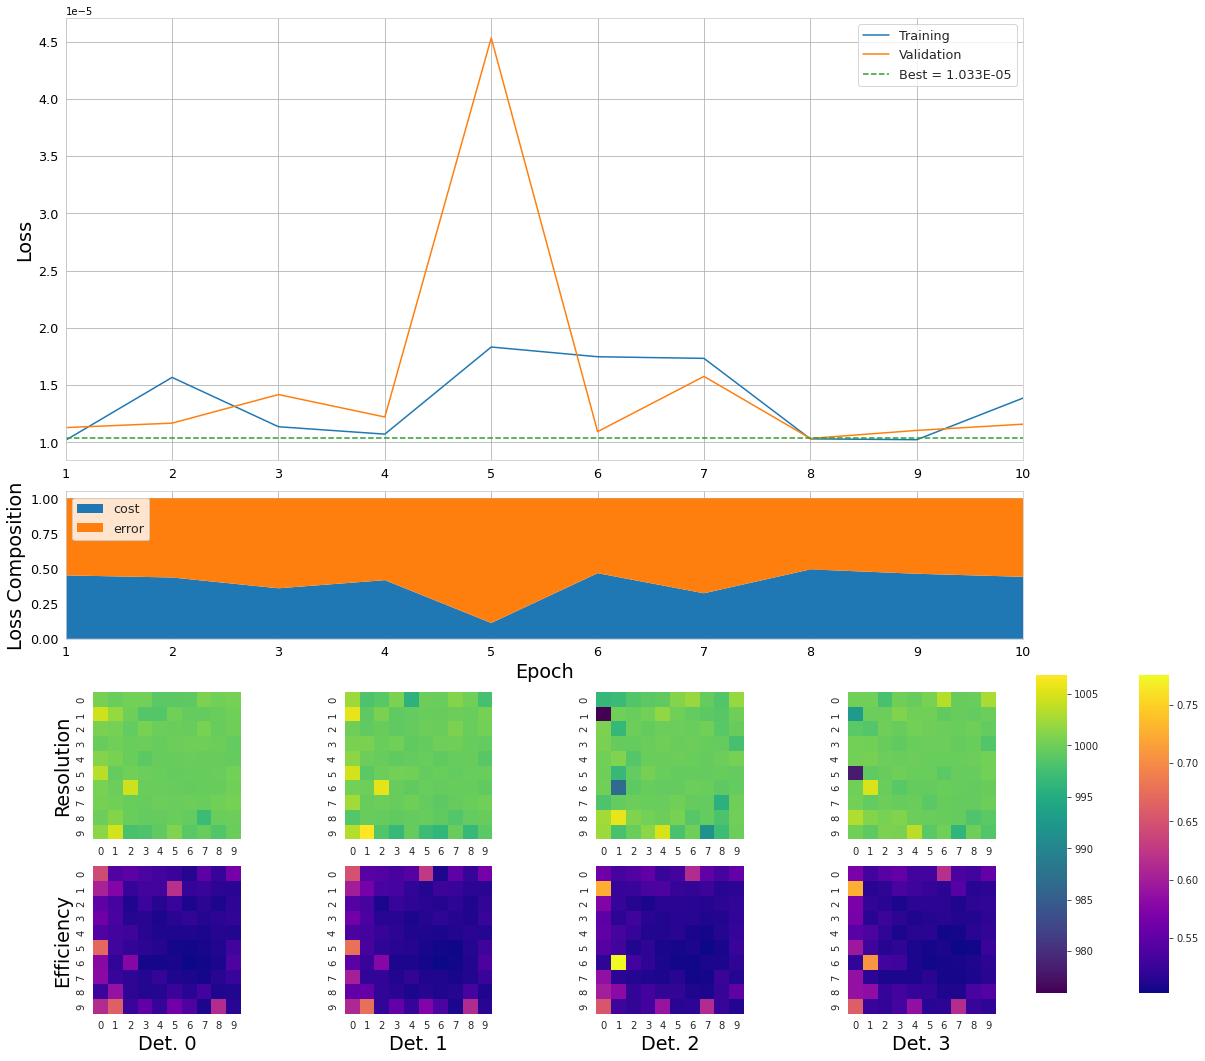

/home/centos/volume/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:207: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


<Figure size 1024x1024 with 0 Axes>

In [28]:
_ = wrapper.fit(n_epochs=10,  # Run for 10 epochs
                passive_bs=1,  # Update every passive volumes (we only have one)
                n_mu_per_volume=1000,  # Use 1000 per passive volume
                mu_bs=100,  # Run the 1000 muons per volume in 10 batches of 100 muons (quicker than a single batch of 1000)
                trn_passives=passives,
                val_passives=passives,  # Evaluate on the training data
                cbs=[NoMoreNaNs(),ml])  # Use these two callbacks during training

In [29]:
ml.get_loss_history()

({'Training': [1.0173475296560889e-05,
   1.56596534459996e-05,
   1.1349657958031246e-05,
   1.0701667488746262e-05,
   1.831491864481196e-05,
   1.7465582523312064e-05,
   1.73228912667789e-05,
   1.0287982450006246e-05,
   1.0216142345550948e-05,
   1.3855541386940217e-05],
  'Validation': [1.1274189501900717e-05,
   1.1663141697570378e-05,
   1.4161556874426028e-05,
   1.2199479809826627e-05,
   4.532749737124157e-05,
   1.092057975730017e-05,
   1.5748111297003554e-05,
   1.0327500728810037e-05,
   1.102673135620032e-05,
   1.1573296317933445e-05]},
 {})

In [30]:
ml.get_results(loaded_best=False)

{'loss': 1.1573296317933445e-05}

### Prediction
Having optimised the detector, we now want to use it to predict the composition of passive volumes without updating; since we're still in simulation, we can assume that we'll always have access to the true composition.
`VolumeWrapper.predict` can be used to run the predictions for each volume in a `PassiveYielder`, and returns a list of pairs of numpy arrays; `[0]` is the prediction, and `[1]` is the truth.
The function reuses a lot of the code used during fitting, running in `fit_params.state = "test"` mode. This means that we still have the functionality to run muons in smaller batches, and the use of callbacks. Indeed, the predictions themselves are collected by a special callback `tomopt.optimisation.callbacks.pred_callbacks.PredHandler`:

```python
class PredHandler(Callback):
    r"""
    Default callback for predictions. Collects predictions for a range of volumes and returns them as list of numpy arrays
    """

    def on_pred_begin(self) -> None:
        super().__init__()
        self.preds: List[Tuple[np.ndarray, np.ndarray]] = []

    def get_preds(self) -> List[Tuple[np.ndarray, np.ndarray]]:
        return self.preds

    def on_x0_pred_end(self) -> None:
        if self.wrapper.fit_params.state == "test":
            self.preds.append((self.wrapper.fit_params.pred.detach().cpu().numpy(), self.wrapper.volume.get_rad_cube().detach().cpu().numpy()))
```

Whilst this is the default prediction callback, we are free to pass our own prediction callbacks to the prediction function as a separate argument to any other callback we wish to use. When running predictions, `on_train_*` methods are not called, instead `on_pred_begin` and `on_pred_end` are called at similar points.

As well as just running inference of the passive volume, we may wish to gather diagnostic information about the hits and scatter locations. `tomopt.optimisation.callbacks.diagnostic_callbacks` contains:
- `ScatterRecord` to record the reconstructed scatter locations in the passive volume
- `HitRecord` to record the reconstructed hit locations in the detectors

Warning: currently these are really only valid when running predictions for a single passive volume (like we will).

In [31]:
from tomopt.optimisation import PredHandler, ScatterRecord, HitRecord

In [32]:
sr = ScatterRecord()
hr = HitRecord()

In [34]:
preds = wrapper.predict(passives, n_mu_per_volume=10000, mu_bs=100, pred_cb=PredHandler(), cbs=[sr,hr])

#### X0 prediction
We can plot the predictions per passive volume (although we only have one) using `tomopt.plotting.predictions.plot_pred_true_x0`, which takes a single prediction and truth pair.

In [35]:
from tomopt.plotting import plot_pred_true_x0

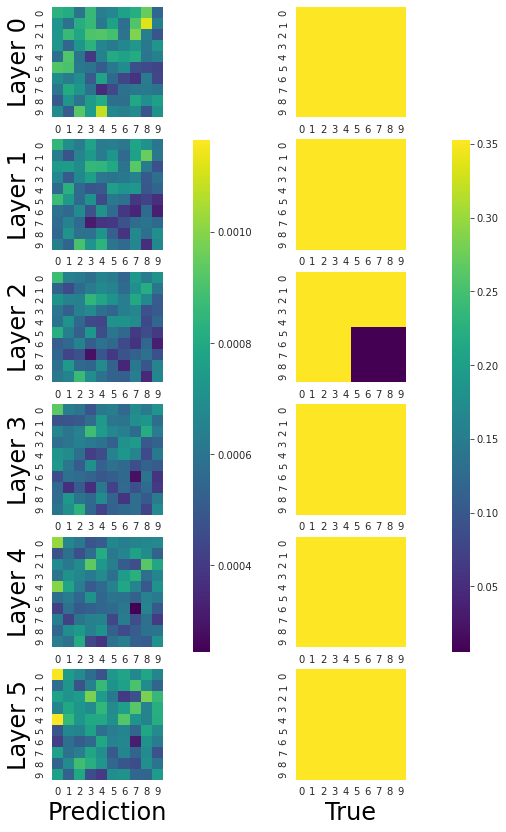

In [36]:
plot_pred_true_x0(preds[0][0], preds[0][1])

We can see the outline of the lead block, however due to the low number of muons used, and the high uncertainty in z, the difference extends over several layers.

#### Diagnostics
Since we passed the `*Record` callbacks during prediction, they will have accumulated their relevant information which we can access by calling their `get_record` function:

In [37]:
scatter_df = sr.get_record(as_df=True)
scatter_df

,x,y,z,layer
0,0.721856,0.311469,0.203075,5
1,0.305928,0.447882,0.368909,4
2,0.191193,0.331724,0.499045,3
3,0.411192,0.822682,0.723951,0
4,0.684110,0.899519,0.495756,3
...,...,...,...,...
5232,0.939659,0.402691,0.354822,4
5233,0.091638,0.422060,0.604063,1
5234,0.808749,0.192355,0.546285,2
5235,0.903527,0.336582,0.343848,4


In [38]:
hit_df = hr.get_record(as_df=True)
hit_df

,x,y,z,layer
0,0.717524,0.135866,0.95,0
1,0.718377,0.159692,0.85,1
2,0.721963,0.320215,0.15,2
3,0.726034,0.341102,0.05,3
4,0.757872,0.713924,0.95,0
...,...,...,...,...
33895,0.917193,0.091112,0.05,3
33896,0.586948,0.425279,0.95,0
33897,0.584379,0.439056,0.85,1
33898,0.569307,0.528374,0.15,2


We can also plot these to get the densities of hits and scatters per layer using the plotting functions in `tomopt.plotting.diagnostics`

In [39]:
from tomopt.plotting import plot_hit_density, plot_scatter_density

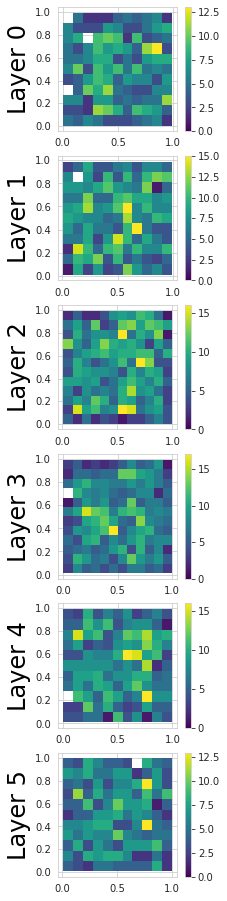

In [40]:
plot_scatter_density(scatter_df)

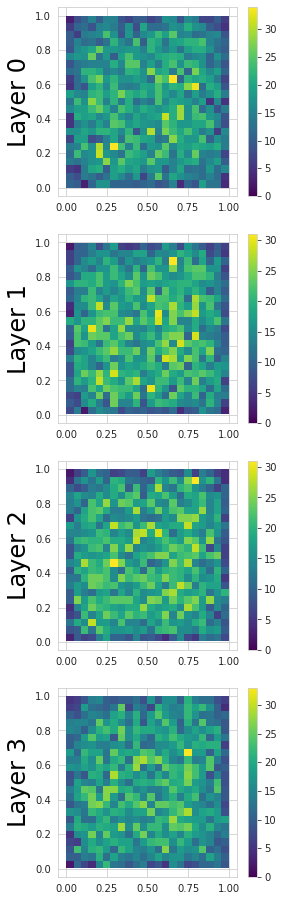

In [41]:
plot_hit_density(hit_df)

From both of these plots we can see then density along the edges is lower, this is due to the fact that hits and scatters are recorded only for muons which stay within the passive volume, so muons which do pass through the edges in one layer are likely to leave the volume and be excluded from the plots.